# Flc-model

author: laquitainesteeve@gmail.com

purpose: feature weights of classifier to predict "good single-units" (>80% agreement score).


**Method**
- 10 minutes of recording 
- extract waveforms kilosort4
- kilosort4's sorting extractor was generated with rtx5090 GPU, so the results slightly change from the original Tesla V100

## Setup 

activate spikebias

In [ ]:
%load_ext autoreload
%autoreload 2
import os
import shutil
import pickle
import copy
import random
import pandas as pd
import spikeinterface as si
import spikeinterface.preprocessing as spre
import spikeinterface.core.template_tools as ttools
from spikeinterface import comparison
from spikeinterface.curation import remove_excess_spikes
from spikeinterface import extract_waveforms
from spikeinterface.postprocessing import compute_principal_components
from spikeinterface.qualitymetrics import compute_quality_metrics as qm
import statsmodels.api as sm
from statsmodels.tools.validation import float_like
# from cebra import CEBRA
# import cebra
# import cebra.models
import torch
import numpy as np
from matplotlib import pyplot as plt
import sklearn
import seaborn as sns
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

print("Spikeinterface", si.__version__)

# set project path
proj_path = "/home/steeve/steeve/epfl/code/spikebias/"
os.chdir(proj_path)

from src.nodes.utils import get_config
from src.nodes import utils
from src.nodes.metrics.quality import get_scores
from src.nodes.models.Flc.models import FlcModel # FLC model
from src.nodes.models.Flc import dataloader
from src.nodes.models.Flc import plotutils as flcplot

# setup waveform extraction parameters

DURATION_SEC = 600          # 10 minutes
CHUNKS = 50000              # (default = 800000) use smaller chunks to use less RAM
MAX_SPIKES_PER_UNIT = 500   # (default = 500) max number of spikes used per unit
WE_JOB_KWARGS = dict(n_jobs=20, chunk_size=800000, progress_bar=True)
job_kwargs = dict(n_jobs=-1, progress_bar=True)

# model parameters
model_prms = {"seeds": np.arange(0,100,1), "scale_data": False}

# setup paths

# npx spont
RECORDING_NS = "dataset/00_raw/recording_npx_spont/"
KS4_ns_10m = "dataset/01_intermediate/sorting/npx_spont/SortingKS4_10m/"
# GT_ns_10m = cfg_ns["sorting"]["simulation"]["ground_truth"]["10m"]["output"] # KS4 sorting
GT_ns = "dataset/00_raw/ground_truth_npx_spont"
GT_ns_10m = "dataset/00_raw/ground_truth_npx_spont_10m"
# STUDY_ns = cfg_ns["postprocessing"]["waveform"]["sorted"]["study"]["kilosort4"][
#     "10m"
# ]  # WaveformExtractor
STUDY_ns = "dataset/01_intermediate/waveforms/npx_spont/SortingKS4_10m/"
# STUDY_ns_su = '/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/0_silico/neuropixels/concatenated_campaigns/postpro/realism/spike/sorted/study_ks4_10m_single_units'
STUDY_ns_su = "dataset/01_intermediate/waveforms/npx_spont/SortingKS4_10m_single_units"
# quality_path = "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/analysis/sorting_quality/sorting_quality.csv"
quality_path = "dataset/01_intermediate/analysis/sorting_quality/sorting_quality.csv" # sorted unit quality labels

# model save path
error_path = "/gpfs/bbp.cscs.ch/project/proj85/laquitai/spikebias_paper/analysis/sorting_quality/models/cebra/sf_40Khz/error_path_s2s"

# figure parameters
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically between 0.5 and 1
plt.rcParams["axes.linewidth"] = 0.5 #1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
# legend
legend_cfg = {"frameon": False, "handletextpad": 0.5}
tight_layout_cfg = {"pad": 0.001}
LG_FRAMEON = False              # no legend frame

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Spikeinterface 0.100.5


In [63]:
# check for GPU
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("__CUDNN VERSION:", torch.backends.cudnn.version())
    print("__Number CUDA Devices:", torch.cuda.device_count())
    print("__CUDA Device Name:", torch.cuda.get_device_name(0))
    print(
        "__CUDA Device Total Memory [GB]:",
        torch.cuda.get_device_properties(0).total_memory / 1e9,
    )

__CUDNN VERSION: 90501
__Number CUDA Devices: 1
__CUDA Device Name: NVIDIA GeForce RTX 5090
__CUDA Device Total Memory [GB]: 33.660469248


## Functions

In [ ]:
# DATASET -----------------------------------------------------------

def get_good_sorted_unit_ids(
    quality, quality_path: str, sorter: str, exp: str, layer: str, fltd_unit: list
):
    """_summary_

    Args:
        quality (_type_): _description_
        quality_path (str): _description_
        sorter (str): _description_
        exp (str): _description_
        layer (str): _description_
        fltd_unit (list): _description_

    Returns:
        np.array(int): filtered sorted unit ids
    """
    # load quality results
    unit_quality = pd.read_csv(quality_path)

    # select a sorted unit and conditions
    df = unit_quality[
        (unit_quality["quality"].str.contains(quality))
        & (unit_quality["experiment"] == exp)
        & (unit_quality["sorter"] == sorter)
        & (unit_quality["layer"] == layer)
    ]
    # filter units based on previous conditions
    df = df[df["sorted"].isin(fltd_unit)]
    return df["sorted"].values.astype(int)


def get_poor_sorted_unit_ids(
    quality, quality_path: str, sorter: str, exp: str, layer: str, fltd_unit: list
):
    """_summary_

    Args:
        quality (_type_): _description_
        quality_path (str): _description_
        sorter (str): _description_
        exp (str): _description_
        layer (str): _description_
        fltd_unit (list[int]): _description_

    Returns:
        np.array[int]: filtered sorted unit ids
    """
    np.array(fltd_unit).astype(int)

    # load quality results
    unit_quality = pd.read_csv(quality_path)

    # select a sorted unit and conditions
    df = unit_quality[
        (unit_quality["quality"] == quality)
        & (unit_quality["experiment"] == exp)
        & (unit_quality["sorter"] == sorter)
        & (unit_quality["layer"] == layer)
    ]
    df = df[df["sorted"].isin(fltd_unit)]
    return df["sorted"].values.astype(int)


def get_spike_dataset_for(
    unit_ids: np.array,
    we,
    max_spikes: int,
    interval_ms: float,
    sfreq: int,
    downsample: int,
):
    """_summary_

    Args:
        unit_ids (np.array[int]): _description_
        we (_type_): _description_
        max_spikes (int): _description_
        interval_ms (float): _description_
        sfreq (int): _description_
        downsample (int): downsample waveforms to produce
        - a lower sampling frequency (e.g., 2 to reduce a 40 KHz frequency
        to 20 KHz)

    Returns:
        _type_: _description_
    """

    # convert interval in ms to samples
    ttp_sp = we.nbefore
    bef_aft_sp = interval_ms * sfreq / 1000
    interval = np.arange(ttp_sp - bef_aft_sp, ttp_sp + bef_aft_sp, 1).astype(int)

    # get all units nearest channels (with extremum amplitude)
    max_chids = ttools.get_template_extremum_channel(we, peak_sign="both")

    # loop over good units
    # 240 samples (-3 to 3 ms at 40KHz)
    wvs = np.zeros((int(max_spikes * we.nbefore * 2 / downsample), 1))
    unit_label = []
    for unit in unit_ids:

        # get its waveforms (num_spikes, num_samples, num_channels)
        wv = we.get_waveforms(unit_id=unit)

        # get its nearest channel
        c_ids = we.sparsity.unit_id_to_channel_ids[unit]
        max_chid = max_chids[unit]
        max_chid_ix = np.where(c_ids == max_chid)[0][0]

        # get waveform for that channels (2D)
        # and (num_samples, num_spikes)
        # TODO: sample instead of taking the first ones
        wv_i = np.array(wv[:max_spikes, interval[::downsample], max_chid_ix]).flatten()[
            :, None
        ]

        # record waveforms
        wvs = np.hstack([wvs, wv_i])

    wvs = wvs[:, 1:]
    # unit_label = np.array(unit_label)
    unit_label = np.array(unit_ids)
    return wvs, unit_label


def get_sorted_unit_best_score(
    KS4_ns_10m: str,
    GT_ns_10m: str,
    sfreq:int
):
    """Get sorted unit best agreement scores

    Args:
        KS4_ns_10m (str): path of SortingExtractor
        GT_ns_10m (str): path of GroundTruth SortingExtractor

    Returns:
        pd.Series:
        - index_ sorted units
        - values: agreement scores
    """
    # load 
    SortingTrue = si.load_extractor(GT_ns_10m)
    
    # get 10 mins
    SortingTrue = SortingTrue.frame_slice(start_frame=0, end_frame=10 * 60 * sfreq)

    # remove empty units
    SortingTrue = SortingTrue.remove_empty_units()

    # load sorting
    Sorting = si.load_extractor(KS4_ns_10m)

    # compute agreement score
    comp = comparison.compare_sorter_to_ground_truth(
        SortingTrue,
        Sorting,
        match_mode="hungarian",
        exhaustive_gt=True,
        delta_time=1.3,
        compute_labels=True,
        compute_misclassifications=False,
        well_detected_score=0.8,
        match_score=0.8,  # modified
        redundant_score=0.2,  # default - we don't use that info in this analysis
        overmerged_score=0.2,  # default - we don't use that info in this analysis
        chance_score=0.1,  # default - we don't use that info in this analysis
    )
    return comp.agreement_scores.max()


def get_dataset_for(
    we,
    quality_path: str,
    sorter: str,
    exp: str,
    layer: str,
    max_spikes: int,
    flt_unit: list[int],
    interval_ms: float,
    sfreq: int,
    downsample: int,
):
    """get dataset

    Args:
        we (WaveformExtractor): WaveformExtractor
        quality_path (str): path of the pandas dataframe
        - containing sorted unit quality classification
        sorter (str): one of "KS4", "KS3", "KS2.5", "KS2"...
        - contained in the quality dataframe in the "sorter" column
        exp (str): _description_
        layer (str): _description_
        max_spikes (int): _description_
        flt_unit (list[int]): _description_
        interval_ms (float): _description_
        sfreq (int): _description_
        downsample

    Returns:
        _type_: _description_
    """

    # get good units (filtered based on some conditions)
    g_units = get_good_sorted_unit_ids(
        "good", quality_path, sorter, exp, layer, flt_unit
    )
    wvs_good, good_unit_label = get_spike_dataset_for(
        g_units, we, max_spikes, interval_ms, sfreq, downsample
    )

    # poor units (filtered based on some conditions)
    p_units = get_poor_sorted_unit_ids(
        "mixed: overmerger + oversplitter", quality_path, sorter, exp, layer, flt_unit
    )
    wvs_poor, poor_unit_label = get_spike_dataset_for(
        p_units, we, max_spikes, interval_ms, sfreq, downsample
    )

    # spike dataset
    spike_data = np.hstack([wvs_good, wvs_poor]).T

    # quality label (1D discrete, CEBRA can handle only one)
    quality_label = np.hstack(
        [np.array([1] * len(good_unit_label)), np.array([0] * len(poor_unit_label))]
    )

    # unit ids
    unit_ids = np.hstack([g_units, p_units])

    return spike_data, quality_label, unit_ids


def get_dataset_by_layer(
    sort_path: str,
    gt_path: str,
    study: str,
    quality_path: str,
    sorter: str,
    exp: str,
    num_spike: int,
    interval_ms: float,
    downsample: int,
):
    """get a dataset by layer

    Args:
        sort_path (str): _description_
        gt_path (str): ground truth SortingExtractor
        STUDY (str): _description_
        quality_path (str): _description_
        sorter (str): _description_
        exp (str): _description_
        num_spike (int): _description_
        interval_ms (float): _description_
        downsample (int): can be a factor of 1, 2, 3 ...

    Returns:
        dict: _description_
    """

    # calculate the common maximum number
    # of spikes that it is possible to use
    # across all units (the number of spikes of the
    # least active unit)
    Sorting = si.load_extractor(sort_path)
    unit_spike = Sorting.get_total_num_spikes()
    sfreq = Sorting.get_sampling_frequency()
    print("Recording sampling frequency:", sfreq)

    # select unit ids with at least num_spikes
    n_spike = [unit_spike[key] for key in unit_spike]
    if num_spike == None:
        num_spike = min(n_spike)
        flt_unit = [unit for unit in unit_spike]
    else:
        flt_unit = [unit for unit in unit_spike if unit_spike[unit] > num_spike]

    # get waveformExtractor
    we = si.WaveformExtractor.load_from_folder(study)

    # get data for CEBRA by layer
    # L2/3
    # spike_data_l23, quality_label_l23, unit_ids_l23 = get_dataset_for(
    #     we,
    #     quality_path,
    #     sorter,
    #     exp,
    #     "L2/3",
    #     num_spike,
    #     flt_unit,
    #     interval_ms,
    #     sfreq,
    #     downsample,
    # )
    # L4
    spike_data_l4, quality_label_l4, unit_ids_l4 = get_dataset_for(
        we,
        quality_path,
        sorter,
        exp,
        "L4",
        num_spike,
        flt_unit,
        interval_ms,
        sfreq,
        downsample,
    )
    # L5
    spike_data_l5, quality_label_l5, unit_ids_l5 = get_dataset_for(
        we,
        quality_path,
        sorter,
        exp,
        "L5",
        num_spike,
        flt_unit,
        interval_ms,
        sfreq,
        downsample,
    )
    # L6
    spike_data_l6, quality_label_l6, unit_ids_l6 = get_dataset_for(
        we,
        quality_path,
        sorter,
        exp,
        "L6",
        num_spike,
        flt_unit,
        interval_ms,
        sfreq,
        downsample,
    )

    # get best scores of sorted unit
    best_score = get_sorted_unit_best_score(
        sort_path,
        gt_path,
    )
    print("ex. data shape (L4):", spike_data_l4.shape)
    print("ex. label shape (L4):", quality_label_l4.shape)

    # bundle dataset for model 1 (by layer)
    dataset1 = {
        # "data_l23": spike_data_l23,
        "data_l4": spike_data_l4,
        "data_l5": spike_data_l5,
        "data_l6": spike_data_l6,
        # "label_l23": quality_label_l23,
        "label_l4": quality_label_l4,
        "label_l5": quality_label_l5,
        "label_l6": quality_label_l6,
        # "unit_ids_l23": unit_ids_l23,
        "unit_ids_l4": unit_ids_l4,
        "unit_ids_l5": unit_ids_l5,
        "unit_ids_l6": unit_ids_l6,
        "best_score": best_score,
        "nb_spikes": num_spike,
    }
    return dataset1


def get_dataset_pooled(dat1):

    # spike_data = np.vstack(
    #     [dat1["data_l23"], dat1["data_l4"], dat1["data_l5"], dat1["data_l6"]]
    # )
    # quality_label = np.hstack(
    #     [dat1["label_l23"], dat1["label_l4"], dat1["label_l5"], dat1["label_l6"]]
    # )
    # unit_ids = np.hstack(
    #     [
    #         dat1["unit_ids_l23"],
    #         dat1["unit_ids_l4"],
    #         dat1["unit_ids_l5"],
    #         dat1["unit_ids_l6"],
    #     ]
    # )
    spike_data = np.vstack([dat1["data_l4"], dat1["data_l5"], dat1["data_l6"]])
    quality_label = np.hstack([dat1["label_l4"], dat1["label_l5"], dat1["label_l6"]])
    unit_ids = np.hstack(
        [
            dat1["unit_ids_l4"],
            dat1["unit_ids_l5"],
            dat1["unit_ids_l6"],
        ]
    )
    return {"data": spike_data, "label": quality_label, "unit_ids": unit_ids}


def vanilla_cv_split(label, split, seed):

    np.random.seed(seed)

    # get good unit indices
    good_ix = np.where(label)[0]
    n_tr = int(np.floor(len(good_ix) * split))
    shuffled = np.random.permutation(good_ix)
    g_tr_ix = shuffled[:n_tr]

    # get poor unit indices
    poor_ix = np.where(label == 0)[0]
    n_tr = int(np.floor(len(poor_ix) * split))
    shuffled = np.random.permutation(poor_ix)
    p_tr_ix = shuffled[:n_tr]

    # get train and test indices
    tr_ix = np.hstack([g_tr_ix, p_tr_ix])
    all_ix = np.arange(0, len(label), 1)
    test_ix = np.where(~np.isin(all_ix, tr_ix))[0]
    return tr_ix, test_ix


def plot_em(ax, CebraL4_em, quality_label, xlim):
    """plot the embedding, on which dots are
    sorted units colored by sorting quality
    (good in "red", poor in "black")

    Args:
        ax (_type_): axis
        CebraL4_em (np.array): embedding
        quality_label (np.array): quality labels
        - (1: good, 0: poor)

    Returns:
        scat: plot handle
    """
    # set color for good units in red, poor in black
    colr = np.array(["None"] * len(quality_label))
    colr[quality_label == 1] = "r"
    colr[quality_label == 0] = "k"

    # plot
    ax.view_init(20, 45, 0)  # elevation, azimuth, roll
    scat = ax.scatter(
        CebraL4_em[:, 0],
        CebraL4_em[:, 1],
        CebraL4_em[:, 2],
        c=colr,
        edgecolors="w",
        linewidths=0.2,
        s=20,
    )
    # aesthetics
    # disconnect axes (R style)
    ax.spines[["right", "top"]].set_visible(False)
    ax.spines["bottom"].set_position(("axes", -0.05))
    ax.spines["left"].set_position(("axes", -0.05))
    ax.spines["right"].set_visible(False)
    ax.set_xlim(xlim)
    ax.set_ylim(xlim)
    ax.set_zlim(xlim)
    return scat


def plot_model1_em_by_layer(fig, dataset, em, xlim):

    # L2/3
    # ax = fig.add_subplot(1, 4, 1, projection="3d")
    # scat = plot_em(ax, em["l23"], dataset["label_l23"], xlim)
    # ax.set_title("L2/3")
    # L4
    # ax = fig.add_subplot(1, 4, 2, projection="3d")
    ax = fig.add_subplot(1, 3, 1, projection="3d")
    scat = plot_em(ax, em["l4"], dataset["label_l4"], xlim)
    ax.set_title("L4")
    # L5
    # ax = fig.add_subplot(1, 4, 3, projection="3d")
    ax = fig.add_subplot(1, 3, 2, projection="3d")
    scat = plot_em(ax, em["l5"], dataset["label_l5"], xlim)
    ax.set_title("L5")
    # L6
    # ax = fig.add_subplot(1, 4, 4, projection="3d")
    ax = fig.add_subplot(1, 3, 3, projection="3d")
    scat = plot_em(ax, em["l6"], dataset["label_l6"], xlim)
    ax.set_title("L6")
    return fig


def plot_model2_em_by_layer(fig, dataset, em, xlim):
    ax = fig.add_subplot(1, 1, 1, projection="3d")
    scat = plot_em(ax, em, dataset["label"], xlim)
    return ax


def decode(embed_train, embed_test, label_train, label_test):
    """decoding using a k-Nearest Neighbor clustering technique
    We use the fixed number of neighbors 2
    """
    # predict
    decoder = cebra.KNNDecoder(n_neighbors=2, metric="cosine")

    # train kNN on training embedding
    decoder.fit(embed_train, label_train)

    # decode test embedding
    prediction = decoder.predict(embed_test)

    # calculate performance metrics
    # precision and recall are for label 1 ("good" units)
    accuracy = sklearn.metrics.accuracy_score(label_test, prediction)
    bal_accuracy = sklearn.metrics.balanced_accuracy_score(label_test, prediction)
    precision = sklearn.metrics.precision_score(label_test, prediction, pos_label=1)
    recall = sklearn.metrics.recall_score(label_test, prediction, pos_label=1)
    f1_score = sklearn.metrics.f1_score(label_test, prediction, pos_label=1)
    mae = np.median(abs(prediction - label_test))
    r2 = sklearn.metrics.r2_score(label_test, prediction)
    return {
        "metrics": {
            "mae": mae,
            "r2": r2,
            "accuracy": accuracy,
            "bal_accuracy": bal_accuracy,
            "precision": precision,
            "recall": recall,
            "f1_score": f1_score,
        },
        "prediction": prediction,
    }


# UNIT QUALITY METRICS ---------------------------------------


def get_waveformExtractor_for_single_units(
    sort_path: str,
    study_path,
    save_path: str,
    n_sites=384,
    load_if_exists: bool = False,
    add_pca: bool = True,
    n_components=5,
):
    """Setup WaveformExtractors to calculate quality metrics for single units

    Args:
        sort_path (str): _description_
        study_path (_type_): _description_
        save_path (str): _description_
        n_sites (int, optional): _description_. Defaults to 384.
        load_if_exists: bool=False (bool)
        add_pca (bool): only if load_if_exists=False

    Returns:
        _type_: _description_
    """

    # compute
    if not load_if_exists:
        
        # get single units
        Sorting = si.load_extractor(sort_path)
        su_ix = np.where(Sorting.get_property("KSLabel") == "good")[0]
        su_unit_ids = Sorting.unit_ids[su_ix]

        # load WaveformExtractor
        We = si.WaveformExtractor.load_from_folder(study_path)

        # create waveformExtractor for single units
        # which we will keep for all downstream analyses
        # this should speed up computations
        shutil.rmtree(save_path, ignore_errors=True)
        WeSu = We.select_units(unit_ids=su_unit_ids, new_folder=save_path)

        # setup two properties required to calculate some quality metrics
        WeSu.recording.set_property("gain_to_uV", np.ones((n_sites,)))
        WeSu.recording.set_property("offset_to_uV", np.zeros((n_sites,)))

        # augment extractors with pca results
        if add_pca:
            _ = compute_principal_components(
                waveform_extractor=WeSu,
                n_components=n_components,
                mode="by_channel_local",
                **job_kwargs,
            )
    else:
        # or load existing
        WeSu = si.WaveformExtractor.load_from_folder(save_path)
    return WeSu


def add_spike_amplitude_extension(we, n_sites, load_if_exists: bool):
    """Add spike amplitudes to WaveformExtractor

    Args:
        we (WaveformExtractor): _description_
        n_sites (int): typically 384 for neuropixels
        load_if_exists (bool): load if exists

    Returns:
        WaveformExtractor: _description_
    """

    # these two properties are required to compute amplitudes
    we.recording.set_property("gain_to_uV", np.ones((n_sites,)))
    we.recording.set_property("offset_to_uV", np.zeros((n_sites,)))

    # compute spike amplitudes
    # or it as an extension
    if not load_if_exists:
        _ = si.postprocessing.compute_spike_amplitudes(we, outputs="by_unit")
    else:
        we.load_extension("spike_amplitudes")

    # unit-test
    assert we.has_extension("spike_amplitudes"), "load spike_amplitudes extension"
    return we


def get_quality_metrics(KS4_ns_10m, STUDY_ns, STUDY_ns_su, n_sites, load_if_exists):

    # (40s)for single units
    # note: adding PCA takes 3 hours (do once, then set load_if_exists=True)
    WeNs = get_waveformExtractor_for_single_units(
        KS4_ns_10m, STUDY_ns, STUDY_ns_su, n_sites=384, load_if_exists=True
    )
    # add spike amplitudes
    WeNs = add_spike_amplitude_extension(WeNs, n_sites=384, load_if_exists=True)

    # pre-compute Spiketinterface quality metrics
    # 20 secs/unit
    qmetrics = qm(
        WeNs,
        qm_params={
            "amplitude_cutoff": {
                "peak_sign": "neg",
                "num_histogram_bins": 100,
                "histogram_smoothing_value": 3,
                "amplitudes_bins_min_ratio": 0,  # instead of 5
            }
        },
        load_if_exists=load_if_exists,
        skip_pc_metrics=True,
        **job_kwargs,
    )
    qmetrics = qmetrics[
        [
            "amplitude_cutoff",
            "firing_range",
            "firing_rate",
            "isi_violations_ratio",
            "presence_ratio",
            "rp_contamination",
            "rp_violations",
            "sd_ratio",
            "snr",
        ]
    ]

    # add silhouette metric (pca-based but fast enough)
    silhouette = qm(
        WeNs,
        metric_names=["silhouette"],
        **job_kwargs,
    )
    qmetrics["silhouette"] = silhouette.values

    # handle missing metrics
    print("****************** Analysing data completion ***************")

    print("Data completion:", qmetrics.notna().sum())

    print("quality metrics are:", qmetrics.columns)

    return qmetrics


def get_best_site_mad_noise(we, max_chids, unit):

    # get waveforms
    wv, _ = we.get_waveforms(unit_id=unit, with_index=True)

    # get channel ids (sparse)
    c_ids = we.sparsity.unit_id_to_channel_ids[unit]

    # get nearest channel
    max_chid = max_chids[unit]
    max_chid_ix = np.where(c_ids == max_chid)[0][0]
    return wv[:, :, max_chid_ix].flatten()


def mad(data):
    mean_data = np.mean(data)
    return np.mean(np.absolute(data - mean_data))


def get_mad_ratio(spike_amp, noise_amp):
    """calculate an sd_ratio robust to outliers

    Args:
        spike_amp (_type_): _description_
        noise_amp (_type_): _description_

    Returns:
        _type_: _description_
    """
    mad_unit = mad(spike_amp)  # twice smaller than std
    mad_noise = mad(noise_amp)
    return mad_unit / mad_noise


def get_mad_ratio_all_units(unit_ids, WeNS, spike_amp):
    max_chids = ttools.get_template_extremum_channel(WeNS, peak_sign="both")
    mad_ratio = []
    for unit in unit_ids:
        noise_amp = get_best_site_mad_noise(WeNS, max_chids, unit)
        mad_ratio.append(get_mad_ratio(spike_amp[unit], noise_amp))
    return mad_ratio


def load_results(file_path):
    with open(file_path, "rb") as input_file:
        predictions_all = pickle.load(input_file)
    return predictions_all


# MODEL ------------------------------------


def loglike(fit_output, params, scale: float, exog: np.ndarray, endog: np.array):
    """Calculate the log likelihood of observing the true sorting accuracies "endog"
    given the fitted glm model "fit_output"
    you can get by inspecting result_1.model.loglike
    code = inspect.getsource(result_1.model.loglike)
    print(code)

    Args:
        fit_output: fitted glm model
        exog: predictive features used to make predictions
        - independent variables
        endog: true sorting accuracy (dependent variable)

    Note:
        Setting the args as below should produce llf == fit_output.llf
        that is the log likelihood nproduced from fitting the training
        data
        - exog = fit_output.model.exog
        - endog = fit_output.model.endog
    """
    scale = float_like(scale, "scale", optional=True)
    var_weights = np.ones(exog.shape[0])
    freq_weights = np.ones(exog.shape[0])

    # make predictions
    # - same as calling result.model.predict(params, exog)
    linear_preds = np.dot(exog, params) + fit_output.model._offset_exposure
    expval = fit_output.model.family.link.inverse(linear_preds)
    if scale is None:
        scale = fit_output.model.estimate_scale(expval)

    # calculate loglikelihood of data
    llf = fit_output.model.family.loglike(
        endog,  # true sorting accuracy
        expval,  # predicted sorting accuracy
        var_weights,  # 1 by default
        freq_weights,  # 1 by default
        scale,
    )
    return llf


def get_single_fold_mcf_r2(
    model_formula: str,
    dataset: pd.DataFrame,
    split_ratio: float = 0.75,
    seed: int = 0,
    scale_data=False,
):
    """Calculate mcfadden pseudo r-squared for a single fold, sampling
    split_ratio instances of the dataset as train and 1-split_ratio as test

    Args:
        model_formula

    note:
        - mcfadden r2 formula: (1 - result_1.llf / result_1.llnull)
        - produced by statsmodel r2 = test_model.pseudo_rsquared(kind="mcf")

    Returns:
        mcfadden pseudo r-squared (float)
    """
    # GET MCF R2 FOR TEST MODEL
    random.seed(seed)

    # TRAIN -----------
    # calculate 75% of train
    n_train = np.round(split_ratio * dataset.shape[0]).astype(int)

    # sample n_train
    indices = np.arange(0, dataset.shape[0], 1).tolist()
    train_indices = random.sample(indices, n_train)
    train_dataset = dataset.iloc[train_indices, :]

    assert (
        not "quality_label" in dataset.columns
    ), "should drop quality_label from dataset"

    # apply scaling
    if scale_data:
        standard_scaler = StandardScaler()
        predictors = dataset.columns.tolist()
        predictors.remove("sorting_accuracy")
        train_dataset[predictors] = standard_scaler.fit_transform(
            train_dataset[predictors]
        )

    # train model on this fold
    try:
        model_1 = sm.GLM.from_formula(
            model_formula,
            family=sm.families.Binomial(),
            data=train_dataset,
        )
        result_1 = model_1.fit()
    except:
        raise ValueError("Model formula is wrong")

    # TEST -----------
    # create test dataset with remaining instances
    test_indices = list(set(indices) - set(train_indices))
    test_dataset = dataset.iloc[test_indices, :]

    # apply scaling
    if scale_data:
        test_dataset[predictors] = standard_scaler.transform(test_dataset[predictors])

    # reorder test dataset features and add intercept
    # to make predictions and get loglikelihood
    features = result_1.params.index[1:]
    test_features = test_dataset.loc[:, features]
    test_features.insert(0, "intercept", 1)

    # test and eval
    llf = loglike(
        result_1,
        result_1.params,
        None,
        exog=test_features,
        endog=test_dataset["sorting_accuracy"],
    )

    # GET MCF R2 FOR NULL MODEL

    # train
    null_model = sm.GLM.from_formula(
        "sorting_accuracy ~ 1",
        family=sm.families.Binomial(),
        data=train_dataset,
    )
    null_model = null_model.fit()

    # test and eval
    ll_null = loglike(
        null_model,
        null_model.params,
        None,
        exog=np.array([test_features["intercept"]]).T,
        endog=test_dataset["sorting_accuracy"],
    )

    # fix r-squared in case ll_null==0
    if llf > 0 and ll_null == 0:
        return np.nan
    else:
        return 1 - llf / ll_null


def get_crossval_mcf_r2(
    dataset: pd.DataFrame,
    model_formula: str,
    split_ratio: float = 0.75,
    seeds: np.array = np.arange(0, 100, 1),
    scale_data=False,
):
    """Calculate cross-validated mcfadden pseudo r-squared
    on test dataset

    Args:
        model_formula (str): glm model formula
        split_ratio (float, optional): _description_. Defaults to 0.75.
        seeds (np.array, optional): _description_. Defaults to np.arange(0, 100, 1).

    Returns:
        np.array: mcfadden pseudo r-squared
    """
    r2_all = []
    for seed in range(len(seeds)):
        r2 = get_single_fold_mcf_r2(
            model_formula,
            dataset,
            split_ratio=split_ratio,
            seed=seed,
            scale_data=scale_data,
        )
        # print(
        #     "Nan because SVD did not converge in Linear Least Squares because of wrong covariance matrix()"
        # )
        # # can fail if SVD did not converge in Linear Least Squares
        # # because of wrong covariance matrix
        # r2 = np.nan
        r2_all.append(r2)
    return np.array(r2_all)


def get_single_fold_flclassifier_metrics(
    model_formula: str,
    dataset: pd.DataFrame,
    split_ratio: float = 0.75,
    seed: int = 0,
    thresh: float = 0.8,
    scale_data=False,
):
    """Calculate the cross-validated precisions
    and recalls of a fractional logistic classifier
    trained to predict high-quality unit label-

    Args:
        model_formula

    Returns:
        precisions and recalls for each fold
    """
    # GET MCF R2 FOR TEST MODEL
    random.seed(seed)

    # unit-test
    # this is a ground truth label that should not
    # be in the dataset
    assert (
        not "sorting_accuracy" in dataset.columns
    ), "drop sorting_accuracy from dataset"

    # TRAIN -----------
    # calculate 75% of train
    n_train = np.round(split_ratio * dataset.shape[0]).astype(int)

    # sample n_train
    indices = np.arange(0, dataset.shape[0], 1).tolist()
    train_indices = random.sample(indices, n_train)
    train_dataset = dataset.iloc[train_indices, :]

    # apply scaling
    if scale_data:
        standard_scaler = StandardScaler()
        predictors = dataset.columns.tolist()
        predictors.remove("quality_label")
        train_dataset[predictors] = standard_scaler.fit_transform(
            train_dataset[predictors]
        )

    # train model on this fold
    try:
        model_1 = sm.GLM.from_formula(
            model_formula,
            family=sm.families.Binomial(),
            data=train_dataset,
        )
        result_1 = model_1.fit()
    except:
        raise ValueError("Model formula is wrong")

    # TEST -----------
    # create test dataset with remaining instances
    # make sure to drop quality label from test dataset
    test_indices = list(set(indices) - set(train_indices))
    test_dataset = dataset.iloc[test_indices, :]
    test_label = test_dataset["quality_label"]
    test_dataset = test_dataset.drop(columns=["quality_label"])

    # apply scaling
    if scale_data:
        test_dataset[predictors] = standard_scaler.fit_transform(
            test_dataset[predictors]
        )

    # unit-test
    assert not "quality_label" in test_dataset.columns, "drop quality label from test"

    # reorder test dataset features and add intercept
    # to make predictions
    features = result_1.params.index[1:]
    test_features = test_dataset.loc[:, features]
    test_features.insert(0, "intercept", 1)

    # unit-test
    assert not "quality_label" in features, "drop quality label from features"

    # predict -------------
    # thresholded binary predictions
    predictions = (result_1.predict(test_features) >= thresh).astype(int)
    precision = metrics.precision_score(test_label, predictions)
    recall = metrics.recall_score(test_label, predictions)
    return {"precision": precision, "recall": recall}


def train_classifier_on_full_dataset(
    model_formula: str,
    dataset: pd.DataFrame,
):
    """train the classifier on the full dataset

    Args:
        model_formula

    Returns:
        precisions and recalls for each fold
    """
    # unit-test
    # this is a ground truth label that should not
    # be in the dataset
    assert (
        not "sorting_accuracy" in dataset.columns
    ), "drop sorting_accuracy from dataset"

    # train the model
    try:
        model = sm.GLM.from_formula(
            model_formula,
            family=sm.families.Binomial(),
            data=dataset,
        )
        result = model.fit()
    except:
        raise ValueError("Model formula is wrong")
    return result


def get_crossval_flclassifier_metrics(
    dataset: pd.DataFrame,
    model_formula: str,
    split_ratio: float = 0.75,
    seeds: np.array = np.arange(0, 100, 1),
    thresh: float = 0.8,
    scale_data=False,
):
    """Calculate cross-validated mcfadden pseudo r-squared
    on test dataset

    Args:
        model_formula (str): glm model formula
        split_ratio (float, optional): _description_. Defaults to 0.75.
        seeds (np.array, optional): _description_. Defaults to np.arange(0, 100, 1).

    Returns:
        np.array: mcfadden pseudo r-squared
    """
    results = []
    for seed in range(len(seeds)):
        result = get_single_fold_flclassifier_metrics(
            model_formula,
            dataset,
            split_ratio=split_ratio,
            seed=seed,
            thresh=thresh,
            scale_data=scale_data,
        )
        results.append(result)
    return np.array(results)


def train_test_eval(model_formula, dataset, seeds, scale_data=False):

    # create model
    # model = create_classifier_model(predictive_metrics)
    # print(model)

    # evaluate R2
    rez_metrics = get_crossval_flclassifier_metrics(
        dataset=dataset,
        model_formula=model_formula,
        split_ratio=0.75,
        seeds=seeds,
        thresh=0.8,
        scale_data=scale_data,
    )

    # PERFORMANCE -----------------------------

    # make arrays
    precisions = []
    recalls = []
    for m_i in rez_metrics:
        precisions.append(m_i["precision"])
        recalls.append(m_i["recall"])

    # precision
    print("\nprecision:")
    print("median:", np.nanmedian(precisions))
    print("std:", np.nanstd(precisions))
    print("95% CI:", 1.96 * np.std(precisions) / np.sqrt(len(precisions)))

    # recall
    print("\nrecall:")
    print("median r2:", np.nanmedian(recalls))
    print("std r2:", np.nanstd(recalls))
    print("95% CI:", 1.96 * np.std(recalls) / np.sqrt(len(recalls)))

    # plot performance
    _, ax = plt.subplots(figsize=(0.7, 1))
    df = pd.DataFrame(data=[precisions, recalls], index=["precision", "recall"]).T
    sns.stripplot(ax=ax, data=df, jitter=0.04, color="k", size=3)

    # stats precision
    ax.errorbar(
        x=0,
        y=np.nanmedian(precisions),
        yerr=1.96 * np.std(precisions) / np.sqrt(len(precisions)),  # 95% ci
        marker="o",
        color="orange",
        markeredgecolor="w",
        markersize=5,
        zorder=np.inf,
    )

    # stats recall
    ax.errorbar(
        x=1,
        y=np.nanmedian(recalls),
        yerr=1.96 * np.std(recalls) / np.sqrt(len(recalls)),  # 95% ci
        marker="o",
        color="orange",
        markeredgecolor="w",
        markersize=5,
        zorder=np.inf,
    )

    # disconnect axes (R style)
    ax.spines[["right", "top"]].set_visible(False)
    ax.spines["bottom"].set_position(("axes", -0.05))
    ax.yaxis.set_ticks_position("left")
    ax.spines["left"].set_position(("axes", -0.05))
    ax.spines["right"].set_visible(False)
    # labels
    ax.set_ylim([0, 1])
    return precisions, recalls


def interpret_features_weights(model_formula, dataset, predictive_metrics):

    model_result = train_classifier_on_full_dataset(
        model_formula=model_formula, dataset=dataset
    )
    weights = model_result.params

    # build table of features contributions  ---------------

    # add feature weights
    weights_for_df = weights.drop(index="Intercept")
    weights_df = weights_for_df.to_frame()
    weights_df.columns = ["weights"]

    # add p-values (fit to entire dataset)
    pvalues_df = model_result.pvalues.drop(index="Intercept")
    pvalues_df = pvalues_df.to_frame()
    pvalues_df.columns = ["weight p-value"]
    data_df = pd.merge(
        weights_df,
        pvalues_df,
        left_index=True,
        right_index=True,
    )

    # interpret interceptsl
    print("Intercept:")
    print("- logodds of detected HQ units:", weights["Intercept"])
    odds = np.exp(weights["Intercept"])
    print(
        "- P(Identified HQ units when all features are null):",
        odds / (1 + odds),
    )

    # interpret all features
    odds = np.exp(weights["Intercept"] + data_df["weights"])
    data_df[r"\Delta accuracy"] = np.sign(data_df["weights"]) * odds / (1 + odds)

    # display
    data_df = data_df.sort_values(by=[r"\Delta accuracy"], ascending=False)
    display(data_df)
    return data_df

## Load dataset

* the dataset is a dataframe that contains the sorted single-units (indices), their quality metrics and their quality label ()"good" or "bad" units evaluated with our ground truth, columns)

In [ ]:
%%time

# waveform extraction parameters
FREQ_MIN = 300
REFERENCE = "global"
OPERATOR = "median"
MS_BEFORE = 6 # ms
ms_after = 6
LOAD_WE_IF_EXISTS = True

# load recording
RecordingNS = si.load_extractor(RECORDING_NS)
RecordingNS.set_property('location', RecordingNS.get_property('location')[:,:2])

# preprocess
RecordingNS = spre.highpass_filter(RecordingNS, freq_min=FREQ_MIN)
RecordingNS = spre.common_reference(RecordingNS, reference=REFERENCE, operator=OPERATOR)
display(RecordingNS)

# load ground truth 
GroundTruth = si.load_extractor(GT_ns)
GroundTruth.frame_slice(start_frame=0, end_frame=RecordingNS.get_sampling_frequency() * DURATION_SEC)
GroundTruth.save(folder=GT_ns_10m, overwrite=True)
display(GroundTruth)

# load sorting 
SortingNS = si.load_extractor(KS4_ns_10m)
SortingNS = remove_excess_spikes(SortingNS, RecordingNS)
SortingNS = SortingNS.frame_slice(start_frame=0, end_frame=RecordingNS.get_sampling_frequency() * DURATION_SEC)
display(SortingNS)

/home/steeve/steeve/epfl/code/spikebias/envs/spikebias/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.101.2 is recommended
  warnings.warn(


CommonReferenceRecording: 384 channels - 40.0kHz - 1 segments - 82,319,958 samples 
                          2,058.00s (34.30 minutes) - float32 dtype - 117.76 GiB

/home/steeve/steeve/epfl/code/spikebias/envs/spikebias/lib/python3.9/site-packages/spikeinterface/core/base.py:1079: UserWarning: Versions are not the same. This might lead to compatibility errors. Using spikeinterface==0.103.0 is recommended
  warnings.warn(


NumpyFolderSorting: 1388 units - 1 segments - 40.0kHz

FrameSliceSorting: 520 units - 1 segments - 40.0kHz

### Compute/save waveforms

In [ ]:
%%time 

# extract/save sorted unit waveforms
WeNS = extract_waveforms(RecordingNS, SortingNS, STUDY_ns, mode="folder", sparse=True, ms_before=MS_BEFORE,
                    ms_after=ms_after, max_spikes_per_unit=MAX_SPIKES_PER_UNIT,
                    unit_batch_size=CHUNKS, overwrite=True,
                    seed=0, **WE_JOB_KWARGS)
display("Waveform extractor for sorted units:", WeNS)


# extract/save single-unit waveforms
WeNS_su = get_waveformExtractor_for_single_units(
    KS4_ns_10m, STUDY_ns, STUDY_ns_su, n_sites=384, load_if_exists=False
)
display("Waveform extractor for single units:", WeNS_su)

Fitting PCA:   0%|          | 0/184 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/184 [00:00<?, ?it/s]

WaveformExtractor: 384 channels - 184 units - 1 segments
  before:240 after:240 n_per_units:500 - sparse

CPU times: user 1min 15s, sys: 4min 12s, total: 5min 28s
Wall time: 6min 59s


## Model

Fitting PCA:   0%|          | 0/184 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/184 [00:00<?, ?it/s]

extract amplitudes:   0%|          | 0/2058 [00:00<?, ?it/s]

/home/steeve/steeve/epfl/code/spikebias/envs/spikebias/lib/python3.9/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/steeve/steeve/epfl/code/spikebias/envs/spikebias/lib/python3.9/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/steeve/steeve/epfl/code/spikebias/envs/spikebias/lib/python3.9/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/home/steeve/steeve/epfl/code/spikebias/envs/spikebias/lib/python3.9/site-packages/spikeinterface/qualitymetrics/quality_metric_calculator.py:132: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if

  0%|          | 0/184 [00:00<?, ?it/s]

****************** Analysing data completion ***************
Data completion: amplitude_cutoff        184
firing_range            184
firing_rate             184
isi_violations_ratio    184
presence_ratio          184
rp_contamination        184
rp_violations           184
sd_ratio                184
snr                     184
silhouette              182
dtype: int64
quality metrics are: Index(['amplitude_cutoff', 'firing_range', 'firing_rate',
       'isi_violations_ratio', 'presence_ratio', 'rp_contamination',
       'rp_violations', 'sd_ratio', 'snr', 'silhouette'],
      dtype='object')
2025-10-09 15:36:18,033 - root - dataloader.py - load_dataset - INFO - CURATION ----------------------------
2025-10-09 15:36:18,036 - root - dataloader.py - load_dataset - INFO - nb of units before filtering units with inf feature: 184
2025-10-09 15:36:18,036 - root - dataloader.py - load_dataset - INFO - nb of units after: 184


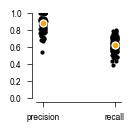

In [83]:
%%time

# create the dataset
data = dataloader.load_dataset(
    quality_path, "NS", "KS4", KS4_ns_10m, STUDY_ns, STUDY_ns_su, GT_ns_10m
)

# instantiate the model
flcmodel = FlcModel(data["predictors"])

# train & eval. w/ cross-val.
results = flcmodel.evaluate(data["dataset"], **model_prms)

# plot
fig, ax = plt.subplots(1, 1, figsize=(1.1, 1.1))
ax = flcplot.plot(ax, results["metric_data"])

## Features correlations

In [85]:
# select uncorrelated metrics
data["dataset"].corr()

,amplitude_cutoff,firing_range,firing_rate,isi_violations_ratio,rp_contamination,rp_violations,sd_ratio,snr,silhouette,mad_ratio,quality_label
amplitude_cutoff,1.000000,-0.156329,-0.154962,0.294967,0.062296,-0.031972,0.425050,0.599958,0.390668,0.246609,-0.102261
firing_range,-0.156329,1.000000,0.996525,-0.081202,0.206018,0.442963,-0.092564,-0.215906,-0.268055,0.020799,0.026902
firing_rate,-0.154962,0.996525,1.000000,-0.080729,0.198882,0.429786,-0.105102,-0.208145,-0.246225,0.001598,0.066000
isi_violations_ratio,0.294967,-0.081202,-0.080729,1.000000,0.436161,0.182912,0.216974,0.288456,0.169565,0.064628,0.023906
rp_contamination,0.062296,0.206018,0.198882,0.436161,1.000000,0.555389,0.072141,-0.032071,-0.040623,0.074808,-0.015572
rp_violations,-0.031972,0.442963,0.429786,0.182912,0.555389,1.000000,-0.001898,-0.077760,-0.107252,0.011088,-0.043278
sd_ratio,0.425050,-0.092564,-0.105102,0.216974,0.072141,-0.001898,1.000000,0.409099,0.054188,0.879606,-0.256566
snr,0.599958,-0.215906,-0.208145,0.288456,-0.032071,-0.077760,0.409099,1.000000,0.563776,0.095749,0.216270
silhouette,0.390668,-0.268055,-0.246225,0.169565,-0.040623,-0.107252,0.054188,0.563776,1.000000,-0.142673,0.147933
mad_ratio,0.246609,0.020799,0.001598,0.064628,0.074808,0.011088,0.879606,0.095749,-0.142673,1.000000,-0.423541


### (10s)Train & eval classifier model

* z-scoring the features marginally changed the results. So we used the raw data, to produce more interpretable weights.


precision:
median: 0.8823529411764706
std: 0.08928325003307916
95% CI: 0.017499517006483514

recall:
median r2: 0.6220238095238095
std r2: 0.08884789760541194
95% CI: 0.01741418793066074


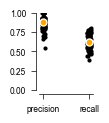

In [ ]:
# parameters
seeds = np.arange(0, 100, 1)

# curate dataset
dataset_c = copy.copy(data["dataset"])

# (10s) evaluate
precisions, recalls = train_test_eval(flcmodel.formula, dataset_c, seeds, scale_data=False)

### Feature weights

* obtained from fitting the same model to the entire dataset, with z-scored feature. 
* note: an increase of mad_ratio by 0.1 (scale is 1 in the table) increases p("good") by 0.1.

In [94]:
# z-score the features
standard_scaler = StandardScaler()
predictors = dataset_c.columns.tolist()
predictors.remove("quality_label")
dataset_c[predictors] = standard_scaler.fit_transform(dataset_c[predictors])
display(dataset_c)

# compute feature weights on entire dataset
table_data = interpret_features_weights(flcmodel.formula, dataset_c, data["predictors"])

,amplitude_cutoff,firing_range,firing_rate,isi_violations_ratio,rp_contamination,rp_violations,sd_ratio,snr,silhouette,mad_ratio,quality_label
198,-0.282089,0.426021,0.487198,-0.157828,-0.398486,-0.248756,3.398728,-0.439852,-0.946623,1.876675,1.0
199,-0.379877,-0.357146,-0.356425,-0.157828,-0.398486,-0.248756,-0.425340,0.717828,0.837074,-0.656819,1.0
213,1.398181,0.212430,0.232852,-0.157828,-0.398486,-0.248756,1.022098,1.987576,0.742010,0.120169,1.0
214,-0.355970,0.354824,0.360025,-0.157828,-0.398486,-0.248756,-0.503933,1.098097,1.116058,-0.743439,1.0
231,-0.329948,-0.214752,-0.152445,-0.157828,-0.398486,-0.248756,-0.494971,-0.560571,-0.541591,-0.471985,1.0
...,...,...,...,...,...,...,...,...,...,...,...
396,-0.359753,-0.641934,-0.622104,-0.157828,-0.398486,-0.248756,-0.412456,-0.544053,-0.825574,-0.209978,0.0
398,-0.270368,0.354824,0.344915,0.000872,2.868329,0.378245,1.077628,-0.430864,-0.946499,2.083861,0.0
400,-0.332284,-0.214752,-0.294728,-0.157828,-0.398486,-0.248756,-0.428799,-0.598953,-0.994342,-0.333232,0.0
405,-0.375433,-0.641934,-0.648546,-0.157828,-0.398486,-0.248756,-0.465901,-0.746767,-0.206396,-0.397962,0.0


Intercept:
- logodds of detected HQ units: -2.6460174357603847
- P(Identified HQ units when all features are null): 0.06623489737447741


,weights,weight p-value,\Delta accuracy
firing_rate,25.236184,0.000005,1.000000e+00
sd_ratio,7.344015,0.000085,9.909688e-01
rp_contamination,0.144078,0.756604,7.572236e-02
isi_violations_ratio,0.126328,0.767663,7.448932e-02
firing_range,-24.788286,0.000006,-1.217400e-12
mad_ratio,-12.773626,0.000011,-2.010639e-07
amplitude_cutoff,-1.395003,0.040850,-1.727582e-02
silhouette,-0.477710,0.105116,-4.213906e-02
rp_violations,-0.400855,0.526909,-4.535267e-02
snr,-0.174073,0.767484,-5.624811e-02


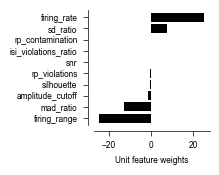

In [95]:
# plot
fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.5))

# plot
ax = table_data.sort_values(by="weights").plot.barh(
    ax=ax, y="weights", color="k", width=0.8
)

# aesthetics
ax.spines[["right", "top"]].set_visible(False)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.spines["left"].set_position(("axes", -0.05))
ax.spines["right"].set_visible(False)

# no legend
ax.legend().set_visible(False)
ax.set_xlabel("Unit feature weights")

plt.savefig("figures/1_curation/fig5_G_weights.svg")

#### (190s)Shuffled control

* TODO: repeat shuffling for many random seeds. I expect 50% median values.

In [97]:
# # parameters
# np.random.seed(0)

# # shuffle labels
# dataset_shuff = copy.copy(dataset_c)
# dataset_shuff["quality_label"] = np.random.permutation(dataset_c["quality_label"])

# # train
# precisions, recalls = train_test_eval(dataset_shuff, data["predictors"], seeds)

### Weight of shuffled model

In [98]:
# table_data = interpret_features_weights(model, dataset_shuff, predictive_metrics)

## Clean up

In [ ]:
os.remove(GT_ns_10m)